## Computing Spring Discharge

Crystal Spring is a 2nd magnitude spring that emanates from the upper Floridan aquifer and discharges into the Hillsborough River just south of Zephyrhills, Fla. This Jupyter Notebook uses stream discharge data from U.S. Geological Survey stream gages 02301990 and 02302010 to compute the discharge from Crystal Spring.

The first step is to import the libraries that we'll need: `pandas`, `numpy`, and `matplotlib`

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')  # this sets some color and line-style options for our graphs

## Read Raw RDB Data From NWIS Web

The raw flow data were downloaded as text files in RDB format from NWIS Web (https://waterdata.usgs.gov/nwis/). There
are several rows of metadata that tell us about the station, which parameters are stored in the file, and a few other things:
<br>
<img src="https://raw.githubusercontent.com/jbellino-usgs/crystal-spring-discharge/master/images/rdb_data_from_nwis.png" alt="Raw RDB data from NWIS" align="left">

In order to get at the discharge data, we will define a function that parses each file and returns only the values we want.

In [2]:
def read_rdb(f):
    
    # Open the file in read-mode
    with open(f, 'r') as f:
        
        # Read the first line
        line = f.readline()
        
        # This sets up an infinite loop to iterate over
        # lines of the header
        while True:
            
            # Look for a hash mark in the first character
            # of the line
            if line[0] == '#':
                
                # If we see a hash mark, read the next line
                line = f.readline()
                
            else:
                
                # If we don't see a hash mark, the line
                # corresponds with the column names for the data
                columns = line.split('\t')
                
                # burn the next line which contains field 
                # width and type and then break the infinite loop
                f.readline()
                break
        
        # now we can read the rest of the file, pass the column names explicitly
        # pd.read_csv() is a pandas function we can use to read text files
        # holding columnar data. The result is a pandas DataFrame object which 
        # can be thought of as a spreadsheet--1 or more columns of data of varying
        # types (floats, integers, dates, text)
        df = pd.read_csv(f,
                         header=None,
                         names=columns,
                         sep='\t',
                         converters={'site_no': str},
                         parse_dates=[2],
                         index_col=[2])
        
        # The RDB file has many more fields than we are interested in. The field
        # holding discharge data will have the string "00060" in it (this is the
        # parameter code for discharge in the NWIS database). The name of the field
        # will change from site to site as there are other pieces of information
        # included in the field name that come out of the database.
        # Let's find the discharge field name for this file:
        q_field = []  # this is an empty list
        for column in df.columns:
            
            # Look for the string "00060", but ignore the field if it also contains
            # the string "cd" as that field tells us whether the data are provisional
            # or approved.
            if '00060' in column and 'cd' not in column:
                
                # if we've found the column, append it to our empty list
                q_field.append(column)
                
        # The "pythonic" way of doing this is with list-comprehension
        q_field = [c for c in df.columns if '00060' in c and 'cd' not in c]
        
        # Now lets grab just this (hopefully) 1 field from the DataFrame
        q = df[q_field]
        
        # Let's rename the field to something more descriptive
        q.columns = ['discharge']
    
    # Return this column of data back out of the function when we are done
    return q['discharge']

Next, we use our function to load data from NWIS Web for USGS gaging stations above (02301990) and below (02302010) Crystal Springs.

In [3]:
below = read_rdb(r'data\dv_02302010')
below.head()  # Show just the first few records so we can see what we're working with

datetime
1995-05-01    54.0
1995-05-02    54.0
1995-05-03    54.0
1995-05-04    54.0
1995-05-05    54.0
Name: discharge, dtype: float64

In [4]:
above = read_rdb(r'data\dv_02301990')
above.head()

datetime
1995-05-01    18.0
1995-05-02    16.0
1995-05-03    16.0
1995-05-04    16.0
1995-05-05    16.0
Name: discharge, dtype: float64

We can now compute spring discharge as the difference in flow between the upstream and downstream gages.

In [5]:
spring = below - above
spring.head()

datetime
1995-05-01    36.0
1995-05-02    38.0
1995-05-03    38.0
1995-05-04    38.0
1995-05-05    38.0
Name: discharge, dtype: float64

## Plot the Data

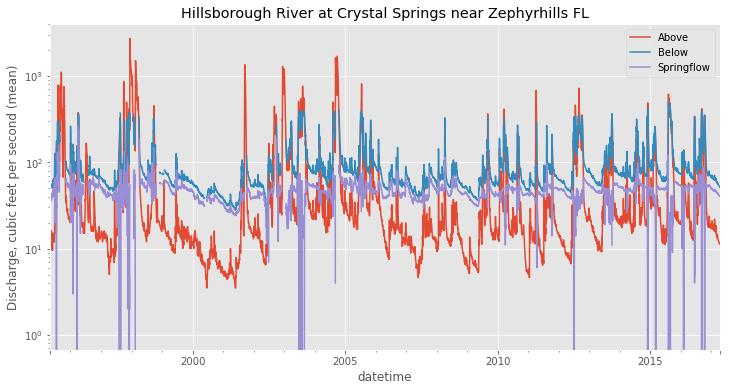

In [6]:
# Create a figure object and axes object on which we will plot the data
# A single figure can contain many axes objects as multiple subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Add the discharge plots
title = 'Hillsborough River at Crystal Springs near Zephyrhills FL'
above.plot(title=title, label='Above', logy=True)
below.plot(label='Below')
spring.plot(label='Springflow')

# Set the y-axis label
ax.set_ylabel('Discharge, cubic feet per second (mean)')

# Add a legend and display the figure
plt.legend()
plt.show()

## Compute and Plot Percent Contribution to Total Flow

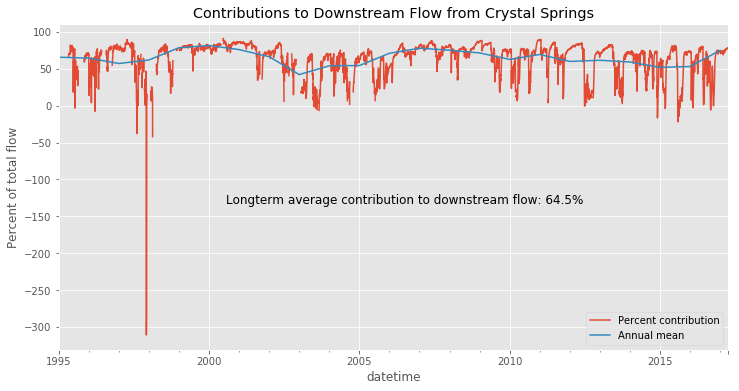

In [7]:
# Create a pyplot object and set title and y-axis label
fig, ax = plt.subplots(figsize=(12, 6))
title = 'Contributions to Downstream Flow from Crystal Springs'
ax.set_ylabel('Percent of total flow')

# Compute percent contribution
pct = (spring / below) * 100
pct.plot(title=title, label='Percent contribution')
pct.resample('A').mean().plot(label='Annual mean')

# add some text to the plot
s = 'Longterm average contribution to downstream flow: {:.1f}%'.format(pct.mean())
t = ax.text(.25, .45, s, size=12, transform=ax.transAxes)

plt.legend()
plt.show()

## Look at a flow reversal event in November/December 1997

During a heavy rainfall event, river water flowed back into the spring vent causing a temporary reversal of flow.

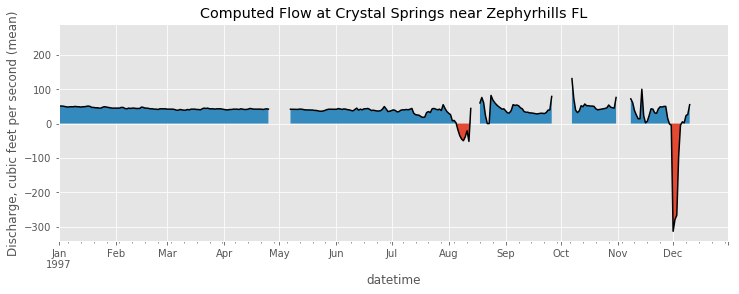

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('Discharge, cubic feet per second (mean)')
title = 'Computed Flow at Crystal Springs near Zephyrhills FL'

year = '1997'
spring[year].plot(figsize=(12, 4), title=title, color='black')

spring_gt0 = spring[spring > 0]
spring_lt0 = spring[spring <= 0]

spring_gt0 = spring_gt0[year]
spring_lt0 = spring_lt0[year]

ax.fill_between(spring.index, spring, where=spring<0, interpolate=True)
ax.fill_between(spring.index, spring, where=spring>0, interpolate=True)

plt.show()